In [1]:
import numpy as np
import pymc as pm
import arviz as az
import math
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def normal_logp_pm(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

In [14]:
n = 20
p = 2

# Design matrix X
X = np.random.normal(size=(n, p))

# For beta
beta_mu_0 = np.zeros(p)
beta_cov_0 = np.eye(p)
Beta_0 = np.zeros(p)

#phi
alpha0 = 1
beta0 = 1
phi0 = 1

y_0 = np.zeros(n)

In [12]:
np.zeros(p)

array([0., 0.])

# HypothesisBias Against when p < n

In [29]:
with pm.Model() as mh:
    
    phi_ = pm.Gamma("phi_", alpha = alpha0, beta = beta0, shape = 1)
    beta = pm.MvNormal("beta", mu=beta_mu_0, cov=beta_cov_0 / phi_, shape=p)
    y = pm.Normal('y', mu=pm.math.dot(X, beta), tau = phi_, shape = n)

# Prior predictive densities
    prior_beta = pm.Deterministic("prior_beta", pm.logp(pm.MvNormal.dist(mu=beta_mu_0, cov=beta_cov_0 / phi0, shape=p), Beta_0))
    prior_pd_phi = pm.Deterministic("prior_pd_phi", pm.logp(pm.Gamma.dist(alpha=alpha0, beta=beta0),phi0))
    prior_y = pm.Deterministic("prior_y", pm.logp(pm.Normal.dist(mu=pm.math.dot(X, beta_mu_0), tau=phi0), y_0))

# Posterior Phi    
    Xb = pm.math.dot(X, Beta_0)
    
    # Calculate ||y - Xb||^2
    residual = y - Xb
    norm_residual_squared = pm.math.sum(pm.math.sqr(residual))

    #Σ(X)
    sigma_x = pm.math.matrix_inverse(pm.math.dot(X.T, X) + pm.math.matrix_inverse(beta_cov_0))
    
    # Calculate (Xb)'(I_n - XΣ(X)X')Xb
    I_n = np.eye(n)
    X_Sigma_XT = pm.math.dot(X, pm.math.dot(sigma_x, X.T))
    projection_matrix = I_n - X_Sigma_XT
    quadratic_term = pm.math.dot(Xb.T, pm.math.dot(projection_matrix, Xb))
    
    # Posterior predictive densities
    posterior_phi_alpha = alpha0 + n/2
    posterior_phi_beta = (norm_residual_squared + quadratic_term + 2 * beta0)/2
    posterior_phi = pm.Deterministic("posterior_phi", pm.logp(pm.Gamma.dist(alpha=posterior_phi_alpha, beta=posterior_phi_beta),phi0))

# Posterior Beta
    posterior_beta_mu = pm.math.dot(sigma_x,pm.math.dot(X.T, Xb))
    posterior_beta_sigma = sigma_x/phi0
    posterior_beta = pm.Deterministic("posterior_beta", normal_logp_pm(Beta_0, posterior_beta_mu, posterior_beta_sigma))

#Posterior X*Beta
    posterior_y = pm.Deterministic("posterior_y", pm.logp(pm.Normal.dist(mu=Xb, tau=phi0), y_0))

    logBR_phi = pm.Deterministic("logBR_phi", posterior_phi - prior_pd_phi)
    logBR_beta = pm.Deterministic("logBR_beta", posterior_beta - prior_beta)
    logBR_y = pm.Deterministic("logBR_y", posterior_y - prior_y)

#Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.Normal.dist(mu=pm.math.dot(X, beta_mu_0), tau=phi0), y_0).sum())
    
with mh:
    idata_h = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi_, beta, y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Hypothesis: bias against for $\\phi$ in Regression when n=20')

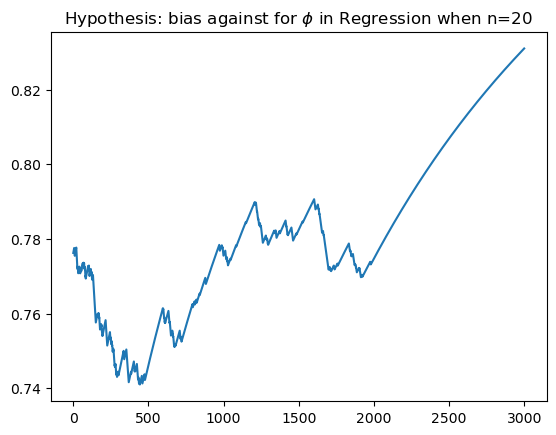

In [17]:
burn = 1000

bias_against_phi = idata_h.posterior['logBR_phi'].values.ravel()<=0
t_phi = bias_against_phi.shape[0]
bias_against_mci_phi = bias_against_phi.cumsum()/np.arange(1,t_phi+1)
plt.plot(bias_against_mci_phi[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for $\phi$ in Regression when n={}".format(n))

Text(0.5, 1.0, 'Hypothesis: bias against for $\\beta$ in Regression when n=20')

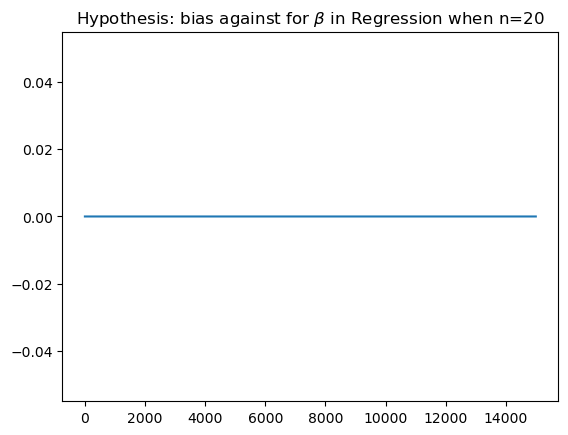

In [18]:
burn = 1000

bias_against_beta = idata_h.posterior['logBR_beta'].values.ravel()<=0
t_beta = bias_against_beta.shape[0]
bias_against_mci_beta = bias_against_beta.cumsum()/np.arange(1,t_beta+1)
plt.plot(bias_against_mci_beta[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for $\\beta$ in Regression when n={}".format(n))

Text(0.5, 1.0, 'Hypothesis: bias against for $y$ in Regression when n=20')

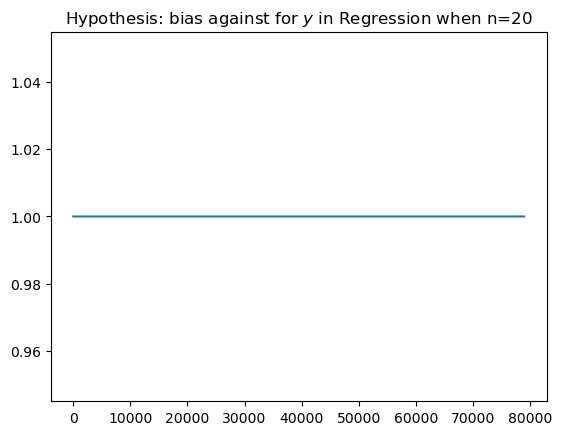

In [19]:
burn = 1000

bias_against_beta = idata_h.posterior['logBR_y'].values.ravel()<=0
t_beta = bias_against_beta.shape[0]
bias_against_mci_beta = bias_against_beta.cumsum()/np.arange(1,t_beta+1)
plt.plot(bias_against_mci_beta[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for  $\mu = X\\beta$  in Regression when n={}".format(n))

## Simulation

In [55]:
x_samples[:, :, :, np.newaxis]

array([[[[ -0.22122211],
         [  1.1938528 ],
         [  0.94133763],
         ...,
         [  0.21242067],
         [  0.47140869],
         [ -1.02069119]],

        [[  0.19455506],
         [  0.43123349],
         [ -0.46705592],
         ...,
         [ -1.1298279 ],
         [ -0.5332722 ],
         [ -1.56277068]],

        [[  0.69954229],
         [  0.56694509],
         [  1.733165  ],
         ...,
         [ -0.92631731],
         [  0.54078285],
         [ -2.2346968 ]],

        ...,

        [[ -0.02155262],
         [  2.37591685],
         [ -0.31107166],
         ...,
         [ -0.82368858],
         [ -0.02886366],
         [  0.84787793]],

        [[  0.93710059],
         [ -1.23276584],
         [ -0.15975711],
         ...,
         [  2.04995079],
         [ -0.5429497 ],
         [ -0.41380002]],

        [[ -0.66562387],
         [  1.7746737 ],
         [  2.68588183],
         ...,
         [ -1.42223607],
         [  0.08019442],
         [  0.536

In [58]:
# Calculate the bias against the prior hypothesis
bias_against = idata_h.posterior["logBR_phi"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
phi_samples = idata_h.posterior['phi_'].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata_h.posterior['y'].values  # Shape (chains, draws, n)
# Expand dimensions to align for broadcasting
phi_expanded = np.expand_dims(phi_samples, axis=(0, 1, 2))
# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], Beta_0, 1/phi_expanded).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata_h.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against for $\phi$  n={}".format(n))
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (4,1000,20,2) (1,1,1,1000) 

C:\Users\23639\AppData\Local\Temp\ipykernel_3196\2379036754.py:15: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


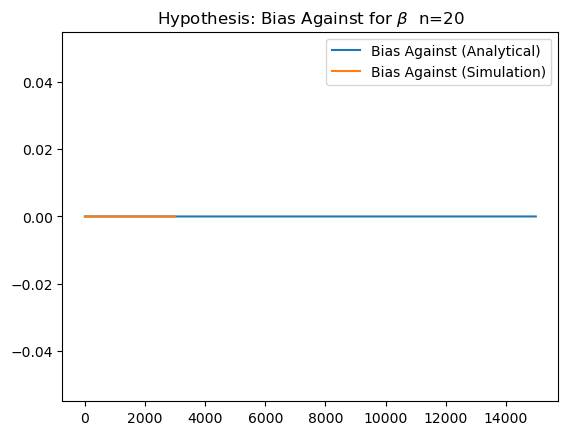

In [31]:
# Calculate the bias against the prior hypothesis
bias_against = idata_h.posterior["logBR_beta"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata_h.posterior['beta'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata_h.posterior['y'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata_h.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against for $\\beta$  n={}".format(n))
plt.legend()
plt.show()

# Estimation: Bias Against when p < n

In [45]:
with pm.Model() as me:
    
    phi_ = pm.Gamma("phi_", alpha = alpha0, beta = beta0, shape = 1)
    beta = pm.MvNormal("beta", mu=beta_mu_0, cov=beta_cov_0 / phi_, shape=p)
    y = pm.Normal('y', mu=pm.math.dot(X, beta), tau = phi_, shape = n)

# Prior predictive densities
    prior_beta = pm.Deterministic("prior_beta", pm.logp(pm.MvNormal.dist(mu=beta_mu_0, cov=beta_cov_0, shape=p), beta))
    prior_pd_phi = pm.Deterministic("prior_pd_phi", pm.logp(pm.Gamma.dist(alpha=alpha0, beta=beta0),phi_))
    prior_y = pm.Deterministic("prior_y", pm.logp(pm.Normal.dist(mu=pm.math.dot(X, beta_mu_0), tau=phi0), y))

# Posterior Phi    
    Xb = pm.math.dot(X, beta)
    
    # Calculate ||y - Xb||^2
    residual = y - Xb
    norm_residual_squared = pm.math.sum(pm.math.sqr(residual))

    #Σ(X)
    sigma_x = pm.math.matrix_inverse(pm.math.dot(X.T, X) + pm.math.matrix_inverse(beta_cov_0))
    
    # Calculate (Xb)'(I_n - XΣ(X)X')Xb
    I_n = np.eye(n)
    X_Sigma_XT = pm.math.dot(X, pm.math.dot(sigma_x, X.T))
    projection_matrix = I_n - X_Sigma_XT
    quadratic_term = pm.math.dot(Xb.T, pm.math.dot(projection_matrix, Xb))

    
    # Calculate the expression
    alpha2_expression = norm_residual_squared + quadratic_term + 2 * beta0
    
    # Posterior predictive densities
    posterior_phi_alpha = alpha0 + n/2
    posterior_phi_beta = (norm_residual_squared + quadratic_term + 2 * beta0)/2
    posterior_phi = pm.Deterministic("posterior_phi", pm.logp(pm.Gamma.dist(alpha=posterior_phi_alpha, beta=posterior_phi_beta),phi_))

# Posterior Beta
    posterior_beta_mu = pm.math.dot(sigma_x,pm.math.dot(X.T, Xb))
    posterior_beta_sigma = sigma_x/phi_
    posterior_beta = pm.Deterministic("posterior_beta", normal_logp_pm(beta, posterior_beta_mu, posterior_beta_sigma))

#Posterior X*Beta
    posterior_y = pm.Deterministic("posterior_y", pm.logp(pm.Normal.dist(mu=Xb, tau=phi_), y))

    logBR_phi = pm.Deterministic("logBR_phi", posterior_phi - prior_pd_phi)
    logBR_beta = pm.Deterministic("logBR_beta", posterior_beta - prior_beta)
    logBR_y = pm.Deterministic("logBR_y", posterior_y - prior_y)

#Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.Normal.dist(mu=pm.math.dot(X, beta), tau=phi_), y).sum())
  
with me:
    idata_e = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi_, beta, y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Hypothesis: bias against for $\\phi$ in Regression when n=20')

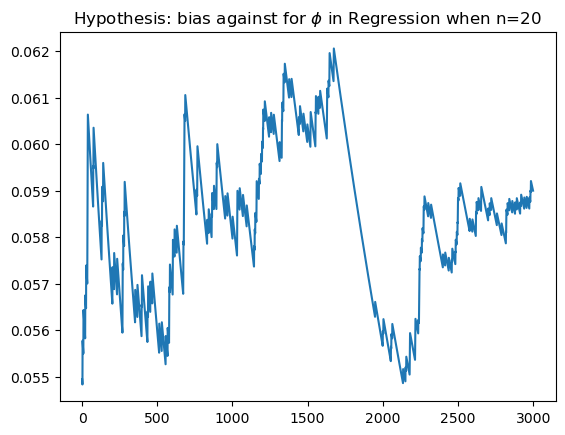

In [46]:
burn = 1000

bias_against_phi = idata_e.posterior['logBR_phi'].values.ravel()<=0
t_phi = bias_against_phi.shape[0]
bias_against_mci_phi = bias_against_phi.cumsum()/np.arange(1,t_phi+1)
plt.plot(bias_against_mci_phi[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for $\phi$ in Regression when n={}".format(n))

Text(0.5, 1.0, 'Hypothesis: bias against for $\\beta$ in Regression when n=20')

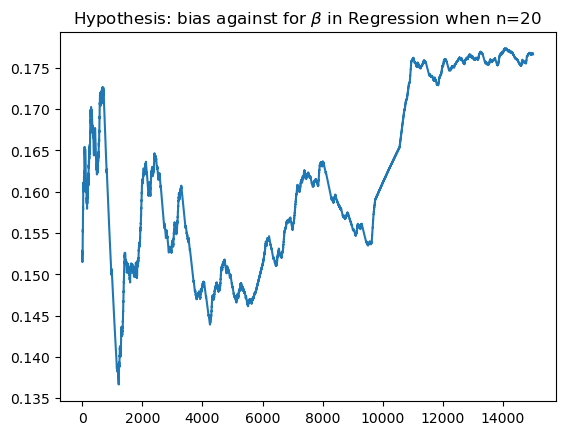

In [47]:
burn = 1000

bias_against_phi = idata_e.posterior['logBR_beta'].values.ravel()<=0
t_phi = bias_against_phi.shape[0]
bias_against_mci_phi = bias_against_phi.cumsum()/np.arange(1,t_phi+1)
plt.plot(bias_against_mci_phi[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for $\\beta$ in Regression when n={}".format(n))

C:\Users\23639\AppData\Local\Temp\ipykernel_3196\2312387145.py:15: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


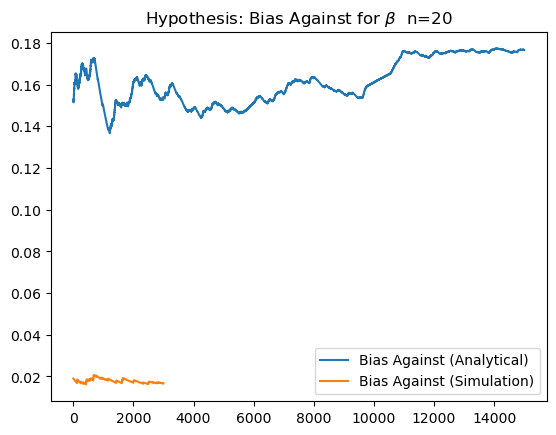

In [48]:
# Calculate the bias against the prior hypothesis
bias_against = idata_e.posterior["logBR_beta"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata_e.posterior['beta'][:, :, 0].values.ravel()#[:1000]  # Use 1000 samples
x_samples = idata_e.posterior['y'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata_e.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against for $\\beta$  n={}".format(n))
plt.legend()
plt.show()

Text(0.5, 1.0, 'Hypothesis: bias against for $\\mu = X\\beta$ in Regression when n=20')

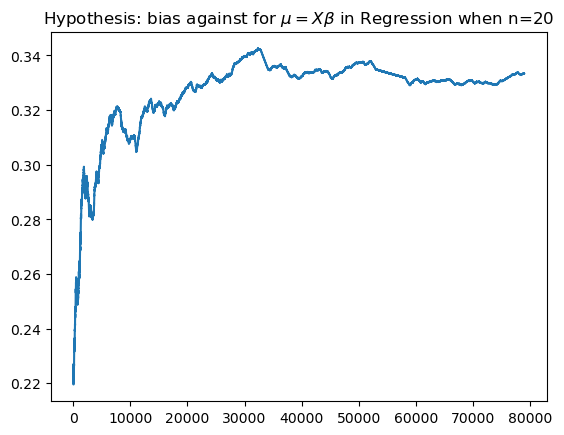

In [51]:
burn = 1000

bias_against_phi = idata_e.posterior['logBR_y'].values.ravel()<=0
t_phi = bias_against_phi.shape[0]
bias_against_mci_phi = bias_against_phi.cumsum()/np.arange(1,t_phi+1)
plt.plot(bias_against_mci_phi[burn:], label='Bias Against (Analytical)')
plt.title("Hypothesis: bias against for $\mu = X\\beta$ in Regression when n={}".format(n))